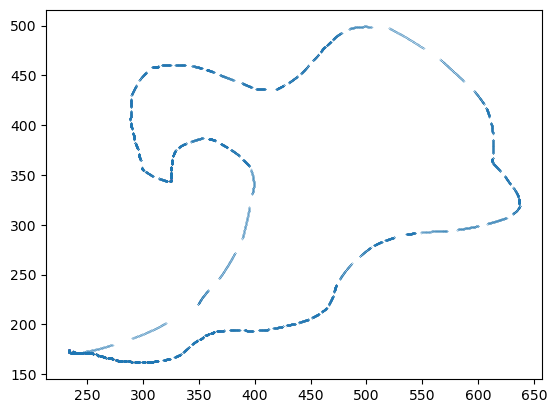

In [144]:
import xml.etree.ElementTree as ET 
import numpy as np

def read_svg(filename):
    namespace = {'svg': 'http://www.w3.org/2000/svg'}
    with open(filename, 'r') as f:
        xml_file = ET.parse(f)
        root_el = xml_file.getroot()
        paths = root_el.findall("svg:path", namespaces=namespace)
        return paths[0].attrib["d"]
    
curve_str = read_svg("Method Draw Vector.svg")


def get_point_lsts(curve_str):
    proxy = ""
    listilist = []
    for ch in curve_str:
        if ch.isalpha():
            if proxy != "":
                listilist.append(proxy)
            proxy = ""
        proxy += ch
    return listilist

plist = get_point_lsts(curve_str)
# print(plist)

def parse_cmd(cmd_str):
    if cmd_str[0] == "c":
        coord_str_list = cmd_str[1:].split(" ")
        coord_matrix = [list(map(float, coord.split(","))) for coord in coord_str_list]
        return { "controls" : list(coord_matrix) }
    return {"move" : list(map(float, cmd_str[1:].split(",")))}

all_commands = [parse_cmd(cmd) for cmd in plist]
all_commands

def function_generator(control_points):
    a, b, c = control_points
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    return lambda t: [(x1 * (1-t)**2) + (2 * x2 * t * (1-t)) + (t**2 * x3), (y1 * (1-t)**2) + (2 * y2 * t * (1-t)) + (t**2 * y3)]

def offset_points(parr, curr):
    return [[point[0] + curr[0], point[1] + curr[1]] for point in parr]

def func_point_list(all_points):
    step_size = 0.01
    x_lst = []
    y_lst = []
    t_vals = np.arange(0, 1, step_size)
    
    org = all_points[0]["move"]

    for point in all_points[1:]:
        func = function_generator(offset_points(point["controls"], org))
        for t in t_vals:
            x,y = func(t)
            x_lst.append(x)
            y_lst.append(y)
        org = [x, y]
    return (x_lst, y_lst)
    
            
x_lst, y_lst = func_point_list(all_commands)

import matplotlib.pyplot as plt
plt.scatter(x_lst, y_lst, s=0.01, alpha=1.0)
plt.show()

In [121]:
def rotating_function_vector(n, t):
    c = np.exp(2j*np.pi * n * t)
    return [c.real, c.imag]


In [130]:
def cmul(c1, c2):
    a,b = c1
    c,d = c2
    return [(a * c) - (b*d), (b*c) + (a*d)]

def bound_t(lst, t):
    L = len(lst) - 1
    idx = t * L
    return lst[int(idx)]
    

def numeric_integration(point_list, n):
    L = len(point_list)
    # bounds of integral: 0 - 1
    riemann_sum = [0, 0]
    step_size = 0.01
    integration_domain = np.arange(0, 1, step_size)
    for t in integration_domain:
        val = cmul(bound_t(point_list, t), rotating_function_vector(-n, t))
        riemann_sum[0] += val[0] * step_size
        riemann_sum[1] += val[1] * step_size
    return riemann_sum

coord_vecs = list(zip(x_lst, y_lst))

coeffs = [numeric_integration(coord_vecs, n) for n in range(100)]

In [127]:
def get_point_from_coeffs(coeffs, t):
    pvec = [0, 0]
    for i, coeff in enumerate(coeffs):
        # take each coefficient, multiply with e^(2pi i n t) and then add
        val = cmul(coeff, rotating_function_vector(i, t))
        pvec[0] += val[0]
        pvec[1] += val[1]
    return pvec

# get_point_from_coeffs(coeffs, 0.8)

In [131]:
zto = np.arange(0, 1, 0.01)
new_x_lst = []
new_y_lst = []
for t_step in zto:
    p = get_point_from_coeffs(coeffs, t_step)
    new_x_lst.append(p[0])
    new_y_lst.append(p[1])


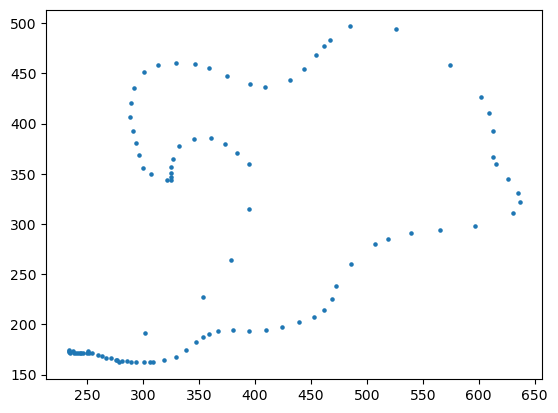

In [132]:
import matplotlib.pyplot as plt
plt.scatter(new_x_lst, new_y_lst, s=5.1, alpha=1.0)
plt.show()

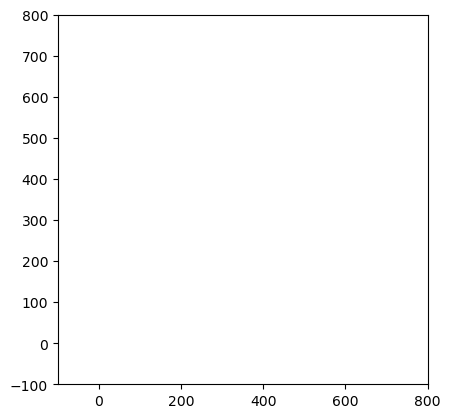

In [147]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.set_xlim(-100, 800)
ax.set_ylim(-100, 800)
ax.set_aspect("equal")

def plot_circle(center, radius):
    circle = patches.Circle((center[0], center[1]), radius, edgecolor='r', facecolor='none')
    ax.add_patch(circle)

def draw_circles(coeff_list, t):
    origin = [0, 0]
    for i,coeff in enumerate(coeff_list):
        # if i == 0:
            # continue
        val = cmul(coeff, rotating_function_vector(i, t))
        radius = (val[0]**2 + val[1]**2) ** 0.5
        # print(radius)
        plot_circle(origin, radius)
        origin[0] += val[0]
        origin[1] += val[1]
    return origin


In [148]:
from matplotlib.animation import FuncAnimation

all_x_points = []
all_y_points = []

def update(frame):
    t = frame / 100
    ax.clear()
    ax.set_xlim(-100, 800)
    ax.set_ylim(-100, 800)
    ax.set_aspect("equal")
    og = draw_circles(coeffs, t)
    all_x_points.append(og[0])
    all_y_points.append(og[1])
    ax.plot(all_x_points, all_y_points, marker='o', linestyle='-', color='b')

ani = FuncAnimation(fig, update, frames=100, interval=50, blit=False)
ani.save('fourier_circles.mp4', writer='ffmpeg')